# Nettoyage du jeu de données "Open Food Facts"

Le jeu de données est téléchargeable sur le site Open Food Facts : [ici](!https://world.openfoodfacts.org/). Il existe différentes manières de le télécharger sur son ordinateur. Ici, on a choisi de faire un import au format csv. On remarque lors du téléchargement que le jeu de données est assez important (environ 4Gb). 

In [1]:
# importation des librairies nécessaires
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [2]:
sns.set_palette("gnuplot2")
sns.set_theme("notebook")

In [3]:
# importation du jeu de données
filename = "datasets/openfoodfacts_data.csv"
df = pd.read_csv(filename, decimal = ',', sep='\t', low_memory=False)

## I - Traitement des valeurs manquantes

Pour ne pas avoir à regarder tout le dataframe, on décide que toutes les colonnes où on observe un pourcentage de valeurs manquantes supérieur à 75% sont supprimées du jeu de données initiales.

In [4]:
# suppression des colonnes avec plus de 75% de valeurs manquantes
df = df.loc[:, df.isnull().mean() <.75]

In [5]:
# Affichage du pourcentage de donneés manquantes
df.isnull().mean() * 100

code                                        0.000000
url                                         0.000000
creator                                     0.000218
created_t                                   0.000000
created_datetime                            0.000000
last_modified_t                             0.000000
last_modified_datetime                      0.000000
product_name                                4.284886
quantity                                   74.571574
brands                                     48.276309
brands_tags                                48.279520
categories                                 52.479937
categories_tags                            52.479992
categories_en                              52.479992
countries                                   0.305111
countries_tags                              0.305383
countries_en                                0.305383
ingredients_text                           61.937775
serving_size                               73.

<AxesSubplot:>

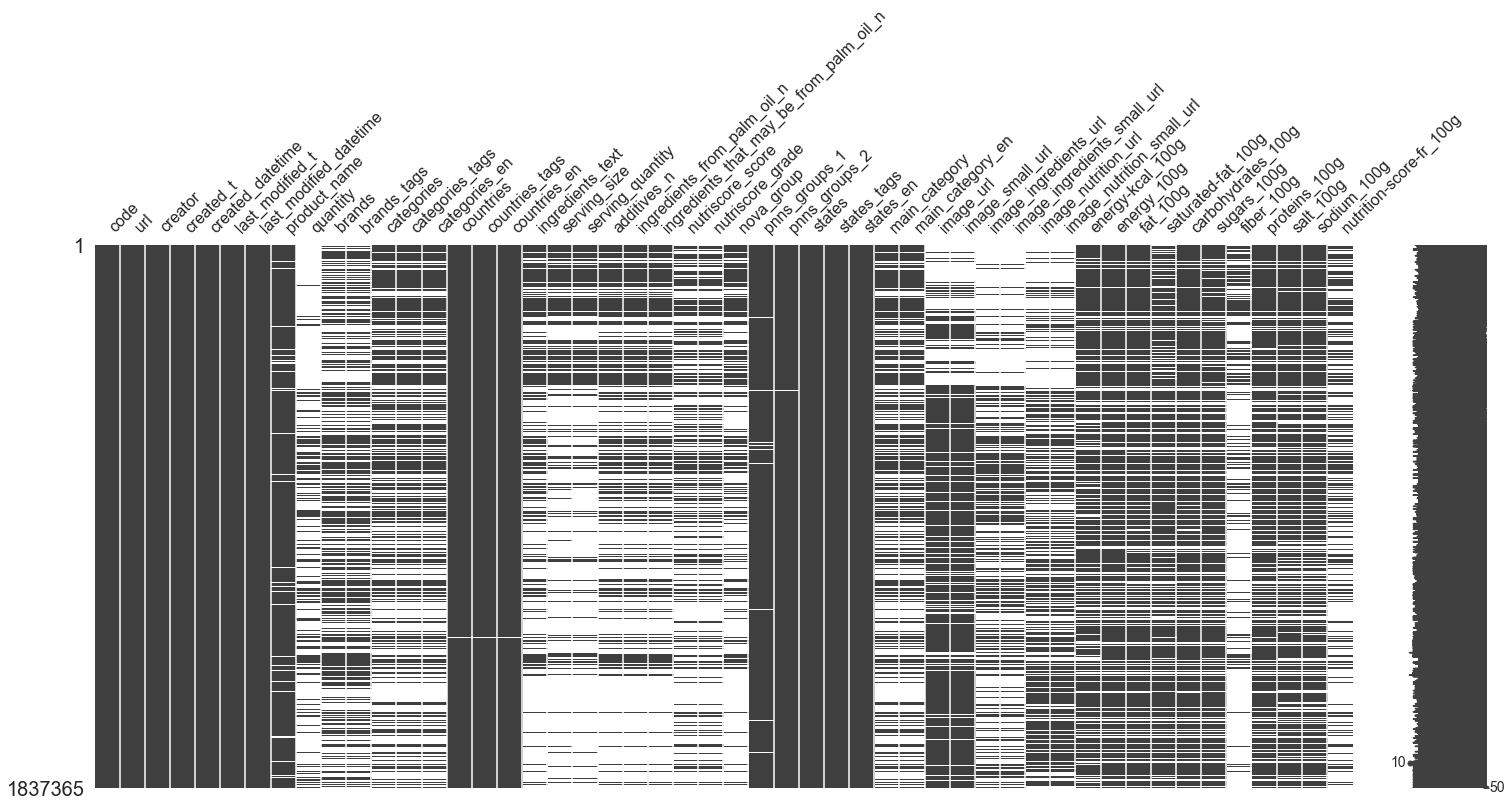

In [6]:
%matplotlib inline
msno.matrix(df)

In [7]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,quantity,brands,...,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
0,00000000000000225,http://world-en.openfoodfacts.org/product/0000...,nutrinet-sante,1623855208,2021-06-16T14:53:28Z,1623855209,2021-06-16T14:53:29Z,jeunes pousses,NaN,endives,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,...,1569,7,3.08,70.1,15,NaN,7.8,1.4,0.56,NaN
2,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,130 g,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000000000003327986,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1574175736,2019-11-19T15:02:16Z,1574175737,2019-11-19T15:02:17Z,Filetes de pollo empanado,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000000000004622327,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1619501895,2021-04-27T05:38:15Z,1619501897,2021-04-27T05:38:17Z,Hamburguesas de ternera 100%,NaN,NaN,...,3661,15.1,6.1,2.6,1,NaN,15.7,2.1,0.84,NaN


Avant de poursuivre le traitement des valeurs manquantes, on va effectuer quelques autres vérifications. 

## II - Modification des types

On va donc modifier les types pour permettre une meilleure imputation. 

In [8]:
# modification des types du dataset en float quand cela est nécessaire
num_col = ["energy-kcal_100g", "energy_100g", "fat_100g", "saturated-fat_100g", "carbohydrates_100g", "proteins_100g", "fiber_100g", "salt_100g", "sodium_100g", "sugars_100g"]


for col in num_col:
    df[col] = pd.to_numeric(df[col])

Pour certaines variables qui sont des variables quantitatives discrètes. On va d'abord faire une imputation par rapport à la valeur médiane pour contrer les possibles valeurs extrêmes. Suite à cela, on va changer leur type en *int* avant de les transformer à nouveau en *object*.

In [9]:
col_cat = ["additives_n", "ingredients_from_palm_oil_n", "ingredients_that_may_be_from_palm_oil_n",
           "nutriscore_score", "nova_group"]

for cols in col_cat:
    df[cols].fillna(df[cols].median(), inplace=True)
    
for col in col_cat:
    df[col] = df[col].astype("int")
    df[col] = df[col].astype("object")

On crée des variables de type *datetime* pour les dates et on va créer une colonne année qui sera utilisée dans la suite de l'analyse. On en profite pour supprimer les colonnes dont on ne se servira pas dans la suite de l'analyse. 

In [10]:
df["created_datetime"] = pd.to_datetime(df["created_datetime"], format="%Y-%m-%d %H:%M:%S.%f", utc=True)
df['created_years'] = pd.to_datetime(df['created_datetime'], format='%d:%m:%Y').dt.year

df["last_modified_datetime"] = pd.to_datetime(df["last_modified_datetime"], format="%Y-%m-%d %H:%M:%S.%f", utc=True)
df['last_modified_years'] = pd.to_datetime(df['last_modified_datetime'], format='%d:%m:%Y').dt.year

In [11]:
df.drop(["created_datetime", "last_modified_datetime"], axis=1, inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1837365 entries, 0 to 1837364
Data columns (total 50 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   code                                     object 
 1   url                                      object 
 2   creator                                  object 
 3   created_t                                int64  
 4   last_modified_t                          int64  
 5   product_name                             object 
 6   quantity                                 object 
 7   brands                                   object 
 8   brands_tags                              object 
 9   categories                               object 
 10  categories_tags                          object 
 11  categories_en                            object 
 12  countries                                object 
 13  countries_tags                           object 
 14  countries_en      

In [13]:
df.describe()

,created_t,last_modified_t,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,created_years,last_modified_years
count,1.837365e+06,1.837365e+06,1.405073e+06,1.457855e+06,1.449790e+06,1.406180e+06,1.449349e+06,1.432417e+06,475926.000000,1.450905e+06,1.389357e+06,1.389353e+06,677532.000000,1.837365e+06,1.837365e+06
mean,1.554378e+09,1.589384e+09,6.250851e+06,4.572169e+36,1.471324e+01,1.226623e+01,2.882682e+01,1.398868e+01,5.135814,8.778622e+00,2.882045e+00,1.152853e+00,9.171624,2.018832e+03,2.019957e+03
std,5.108632e+07,2.937790e+07,7.334753e+09,5.520513e+39,8.538600e+02,8.432970e+03,6.434753e+02,8.358298e+02,1449.557263,1.452166e+02,8.593165e+02,3.437268e+02,8.874919,1.628261e+00,9.921528e-01
min,1.328021e+09,1.333873e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-20.000000,-5.000000e+02,0.000000e+00,0.000000e+00,-15.000000,2.012000e+03,2.012000e+03
25%,1.521058e+09,1.579713e+09,1.010000e+02,4.180000e+02,7.700000e-01,1.000000e-01,3.500000e+00,6.000000e-01,0.000000,1.300000e+00,7.000000e-02,2.800000e-02,2.000000,2.018000e+03,2.020000e+03
50%,1.565864e+09,1.588793e+09,2.610000e+02,1.084000e+03,7.000000e+00,1.800000e+00,1.504425e+01,3.570000e+00,1.600000,6.000000e+00,5.600000e-01,2.240000e-01,10.000000,2.019000e+03,2.020000e+03
75%,1.590926e+09,1.612870e+09,4.000000e+02,1.674000e+03,2.140000e+01,7.140000e+00,5.300000e+01,1.800000e+01,3.600000,1.230000e+01,1.400000e+00,5.600000e-01,16.000000,2.020000e+03,2.021000e+03
max,1.624323e+09,1.624323e+09,8.693855e+12,6.665559e+42,9.999990e+05,9.999999e+06,7.629390e+05,9.999990e+05,999999.000000,1.730000e+05,9.999990e+05,3.999996e+05,40.000000,2.021000e+03,2.021000e+03


In [14]:
df.shape

(1837365, 50)

## III - Formatage des chaînes de caractères

On forme les chaînes de caractères pour rendre leur lecture plus simple et plus agréable. 

In [15]:
# formatage des chaînes de caractères pour faciliter la lecture et la détection des données dupliquées
cols = ["creator", "product_name", "quantity", "brands", "countries", "categories", "ingredients_text",
        "serving_size", "states", "main_category"]

for col in cols:
    if df[col].dtypes == "object":
        df[col] = df[col].str.lower()
        df[col] = df[col].str.capitalize()

## IV - Traitement des informations redondantes

On va retrouver deux types de redondances dans nos données : 
- Celles qui correspondent à des colonnes dont les noms sont différents mais donnent la même information (les colonnes _en ou _tags par exemple)
- Celles qui correspondent à des entrées multiples

Dans un premier temps, nous allons nous créer une liste avec les noms des colonnes à supprimer (avec le suffixe _en ou _tags). Ensuite, on cherchera à supprimer les données dupliquées à l'aide des méthodes spécifiques des dataframes Pandas. 

### A - Suppression des colonnes redondantes

In [16]:
# On supprime les colonnes redondantes avec un suffixe
# Mais aussi celle contenant les urls des images des produits ainsi que les stamps de datetime

drop_cols = ["created_t", "last_modified_t", "brands_tags", "categories_tags", "categories_en", "countries_tags", "countries_en", "states_tags", "states_en", "energy_100g", "salt_100g",
             "main_category_en", "image_small_url", "image_ingredients_small_url", "image_nutrition_small_url", "nutrition-score-fr_100g"]

df.drop(drop_cols, axis=1, inplace=True)

### B - Suppression des entrées multiples

In [17]:
# affichage des entrées multiples dans notre dataset
df[df.duplicated()]

,code,url,creator,product_name,quantity,brands,categories,countries,ingredients_text,serving_size,...,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,created_years,last_modified_years
1383041,7340011495437,http://world-en.openfoodfacts.org/product/7340...,Halal-app-chakib,NaN,NaN,NaN,NaN,Suomi,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021,2021


On remarque qu'il n'y a qu'une seule entrée dupliquée, on va donc la supprimer à l'aide de la méthode *.drop_duplicates()* de Pandas. 

In [18]:
df.drop_duplicates(inplace=True)
df.shape

(1837364, 34)

Cette étape a mené à la suppression de 16 colonnes et d'une entrée (ligne). 

## V - Détections et corrections des anomalies

Pour détecter les anomalies et identifier le type de correction à effectuer, on va commencer par les visualiser à l'aide de boîtes à moustaches. Pour étayer cette analyse, on va aussi générer un tableau contenant les différentes informations statistiques pour mieux identifier la nature de nos anomalies. 

### A) Visualisation et identification des anomalies

- Détection graphique

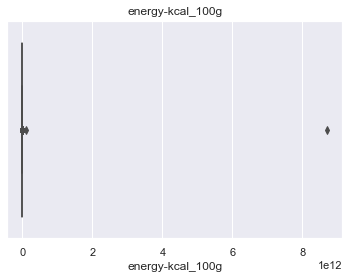

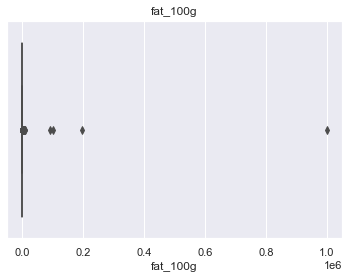

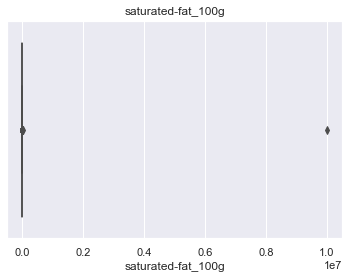

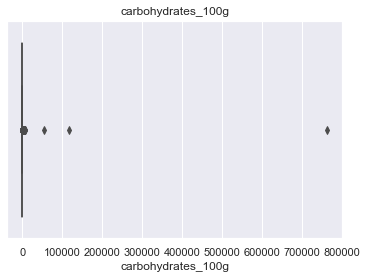

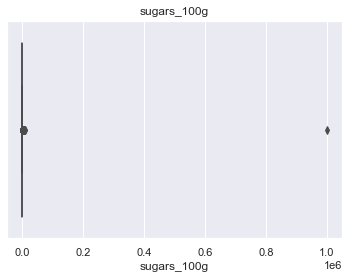

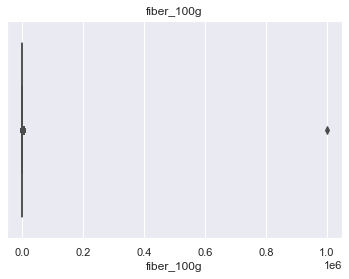

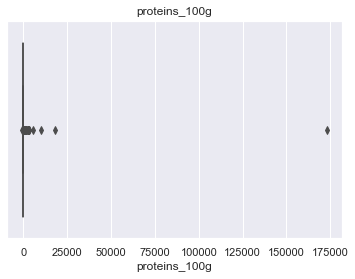

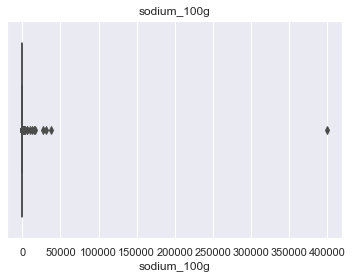

In [19]:
# Création des boîtes à moustache pour détecter les anomalies des variables quantitatives
for var in df.columns:
    if df[var].dtypes == 'float64':
        sns.boxplot(x=var, data=df)
        plt.title(var)
        plt.show()

- Détection numérique

In [20]:
df.describe()

,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,created_years,last_modified_years
count,1.405073e+06,1.449790e+06,1.406180e+06,1.449349e+06,1.432417e+06,475926.000000,1.450905e+06,1.389353e+06,1.837364e+06,1.837364e+06
mean,6.250851e+06,1.471324e+01,1.226623e+01,2.882682e+01,1.398868e+01,5.135814,8.778622e+00,1.152853e+00,2.018832e+03,2.019957e+03
std,7.334753e+09,8.538600e+02,8.432970e+03,6.434753e+02,8.358298e+02,1449.557263,1.452166e+02,3.437268e+02,1.628261e+00,9.921528e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-20.000000,-5.000000e+02,0.000000e+00,2.012000e+03,2.012000e+03
25%,1.010000e+02,7.700000e-01,1.000000e-01,3.500000e+00,6.000000e-01,0.000000,1.300000e+00,2.800000e-02,2.018000e+03,2.020000e+03
50%,2.610000e+02,7.000000e+00,1.800000e+00,1.504425e+01,3.570000e+00,1.600000,6.000000e+00,2.240000e-01,2.019000e+03,2.020000e+03
75%,4.000000e+02,2.140000e+01,7.140000e+00,5.300000e+01,1.800000e+01,3.600000,1.230000e+01,5.600000e-01,2.020000e+03,2.021000e+03
max,8.693855e+12,9.999990e+05,9.999999e+06,7.629390e+05,9.999990e+05,999999.000000,1.730000e+05,3.999996e+05,2.021000e+03,2.021000e+03


### B) Anomalie liée à la nature des données

Les données nutritives étant pour 100g, elles ne peuvent pas excéder 100g. On va donc supprimer les valeurs superieures à 100g pour les carbohydrates, le sucre, les fibres, les protéines, le sel et le sodium. On va aussi supprimer les valeurs qui sont inférieures à 0. Les aliments les plus caloriques ne peuvent contenir que 900 calories au maximum. On va donc supprimer les valeurs supérieures à 900 kcal et inférieure à 0 en ce qui concerne l'énergie en kcal. 

In [21]:
df_clean = df.copy()
df_clean.shape

(1837364, 34)

In [22]:
cols = ['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', "fiber_100g", "proteins_100g", "sodium_100g"]

for col in cols : 
    ind = df_clean.loc[(df_clean[col] < 0) | (df_clean[col] > 100)].index.to_list()
    df_clean.drop(index=ind, inplace=True)

In [23]:
cols = ["energy-kcal_100g"]

for col in cols : 
    ind = df_clean.loc[(df_clean[col] < 0) | (df_clean[col] > 900)].index.to_list()
    df_clean.drop(index=ind, inplace=True)

In [24]:
df_clean.shape

(1830496, 34)

Ce premier traitement a permis d'enlever 6868 entrées.

### C) Traitement des outliers à l'aide de la médiane (IQR)

On utilise la méthode de l'intervalle interquartile (IQR) pour effectuer un second nettoyage. Les valeurs qui se situent à - 1.5 iqr du premier quartile et à + 1.5 du troisième quartile seront supprimées. 

In [25]:
"""q1 = df.quantile(0.25)
q3 = df.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr"""

'q1 = df.quantile(0.25)\nq3 = df.quantile(0.75)\niqr = q3 - q1\nlower_bound = q1 - 1.5 * iqr\nupper_bound = q3 + 1.5 * iqr'

In [26]:
"""import warnings
warnings.filterwarnings("ignore")

df_clean = df_clean[~((df_clean < lower_bound) | (df_clean> upper_bound)).any(axis=1)]
df_clean.shape"""

'import warnings\nwarnings.filterwarnings("ignore")\n\ndf_clean = df_clean[~((df_clean < lower_bound) | (df_clean> upper_bound)).any(axis=1)]\ndf_clean.shape'

Cette seconde étape a permis de supprimer 538 715 entrées.

**Remarque** :
La méthode de retrait des outliers via l'utilisation des intervales interquartiles a finalement été abandonné car elle n'avait pas lieu d'être. Tout d'abord, on perdait énormément d'informations (*538 715 aliments*). Ensuite, en faisant cela, on ne prenait pas en compte que tous les aliments ne sont pas égaux : il existe des aliments très riches en graisses ou en sucres sans que cela ne soit une erreur.

## D) Vérification du traitement

- Vérification numérique

In [27]:
df_clean.describe()

,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,created_years,last_modified_years
count,1.398308e+06,1.443016e+06,1.399584e+06,1.442621e+06,1.425928e+06,474495.000000,1.444151e+06,1.383347e+06,1.830496e+06,1.830496e+06
mean,2.710078e+02,1.365991e+01,5.105978e+00,2.809860e+01,1.325403e+01,2.982324,8.589264e+00,5.500495e-01,2.018829e+03,2.019956e+03
std,1.913466e+02,1.765049e+01,7.800724e+00,2.802448e+01,1.955123e+01,4.898676,9.794829e+00,2.112396e+00,1.628572e+00,9.921931e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,2.012000e+03,2.012000e+03
25%,1.000000e+02,7.250000e-01,1.000000e-01,3.500000e+00,6.000000e-01,0.000000,1.300000e+00,2.800000e-02,2.018000e+03,2.020000e+03
50%,2.600000e+02,7.000000e+00,1.800000e+00,1.500000e+01,3.571400e+00,1.600000,6.000000e+00,2.240000e-01,2.019000e+03,2.020000e+03
75%,4.000000e+02,2.140000e+01,7.140000e+00,5.300000e+01,1.800000e+01,3.600000,1.228000e+01,5.600000e-01,2.020000e+03,2.021000e+03
max,9.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,100.000000,1.000000e+02,1.000000e+02,2.021000e+03,2.021000e+03


- Vérification graphique

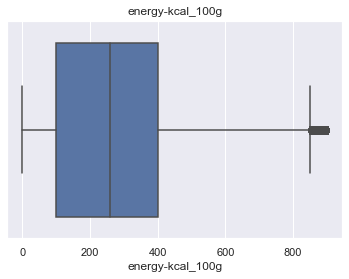

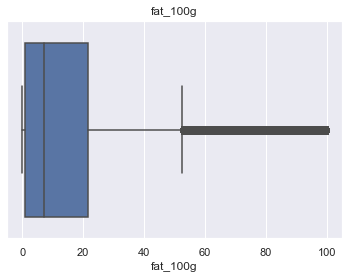

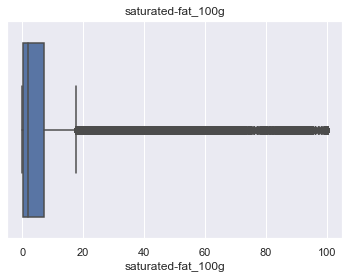

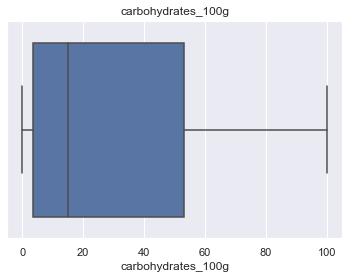

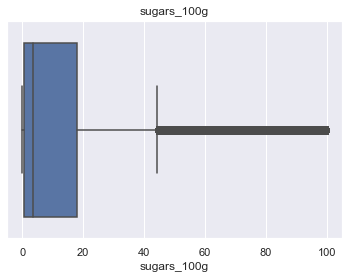

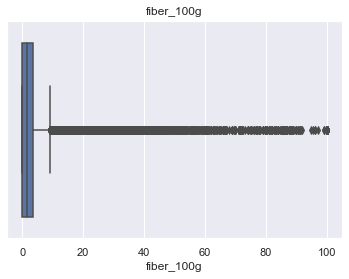

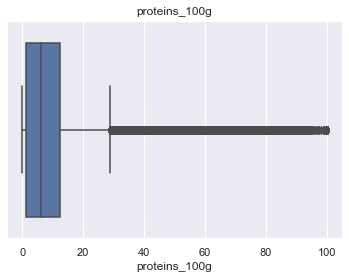

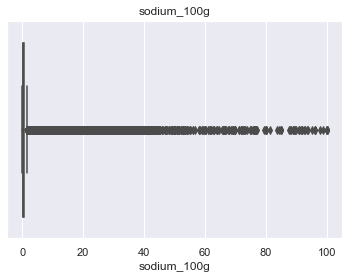

In [28]:
for var in df_clean.columns:
    if df_clean[var].dtypes == 'float64':
        sns.boxplot(x=var, data=df_clean)
        plt.title(var)
        plt.show()

**Remarque :** Initialement trois autres méthodes avaient été employées pour effectuer cette étape de nettoyage. Ces méthodes ont été abandonnées car elles ne permettaient pas l'automatisation du processus, qu'elles demandaient de nombreuses itérations et qu'elles ne prenaient pas en compte la structure des données.

In [29]:
"""outliers = {}

for var in df.columns:
    if df[var].dtypes == 'float64':
        outliers[var] = df[var].max()
        
print(outliers)"""

"outliers = {}\n\nfor var in df.columns:\n    if df[var].dtypes == 'float64':\n        outliers[var] = df[var].max()\n        \nprint(outliers)"

In [30]:
"""index_outliers = []

for k, v in outliers.keys() and outliers.items(): 
    a = df.loc[df[k] == v]
    index_outliers.append(a.index)
    
for i in index_outliers:
    print(i)
      
del index_outliers[-1]
del index_outliers[-1]
del index_outliers[0]"""

'index_outliers = []\n\nfor k, v in outliers.keys() and outliers.items(): \n    a = df.loc[df[k] == v]\n    index_outliers.append(a.index)\n    \nfor i in index_outliers:\n    print(i)\n      \ndel index_outliers[-1]\ndel index_outliers[-1]\ndel index_outliers[0]'

In [31]:
"""drop_index = ['13726', '7941', '4632', '26516', '6901']
df.drop(df.index[drop_index], inplace=True)
df.head()

for var in df.columns:
    if df[var].dtypes == 'float64':
        sns.boxplot(x=var, data=df)
        plt.title(var)
        plt.show()
        
outliers = {}

for var in df.columns:
    if df[var].dtypes == 'float64':
        outliers[var] = df[var].max()
        
print(outliers)

index_outliers = []

for k, v in outliers.keys() and outliers.items(): 
    a = df.loc[df[k] == v]
    index_outliers.append(a.index)
    
for i in index_outliers:
    print(i)
"""

"drop_index = ['13726', '7941', '4632', '26516', '6901']\ndf.drop(df.index[drop_index], inplace=True)\ndf.head()\n\nfor var in df.columns:\n    if df[var].dtypes == 'float64':\n        sns.boxplot(x=var, data=df)\n        plt.title(var)\n        plt.show()\n        \noutliers = {}\n\nfor var in df.columns:\n    if df[var].dtypes == 'float64':\n        outliers[var] = df[var].max()\n        \nprint(outliers)\n\nindex_outliers = []\n\nfor k, v in outliers.keys() and outliers.items(): \n    a = df.loc[df[k] == v]\n    index_outliers.append(a.index)\n    \nfor i in index_outliers:\n    print(i)\n"

## VI - Traitement des valeurs manquantes (suite et fin)

Notre jeu de données a été nettoyé de ces données redondantes et de ces anomalies. On va pouvoir terminer le traitement des valeurs manquantes. On va générer trois datasets qui contiennent plusieurs méthodes de traitement des valeurs manquantes. 

### A) Retrait des valeurs manquantes

Dans ce premier dataset, on va juste supprimer les valeurs manquantes. 

In [32]:
# On travaille sur une copie où l'on va supprimer les valeurs manquantes sans les remplacer

df = df_clean.copy()
df_clean_no_na = df.dropna()

<AxesSubplot:>

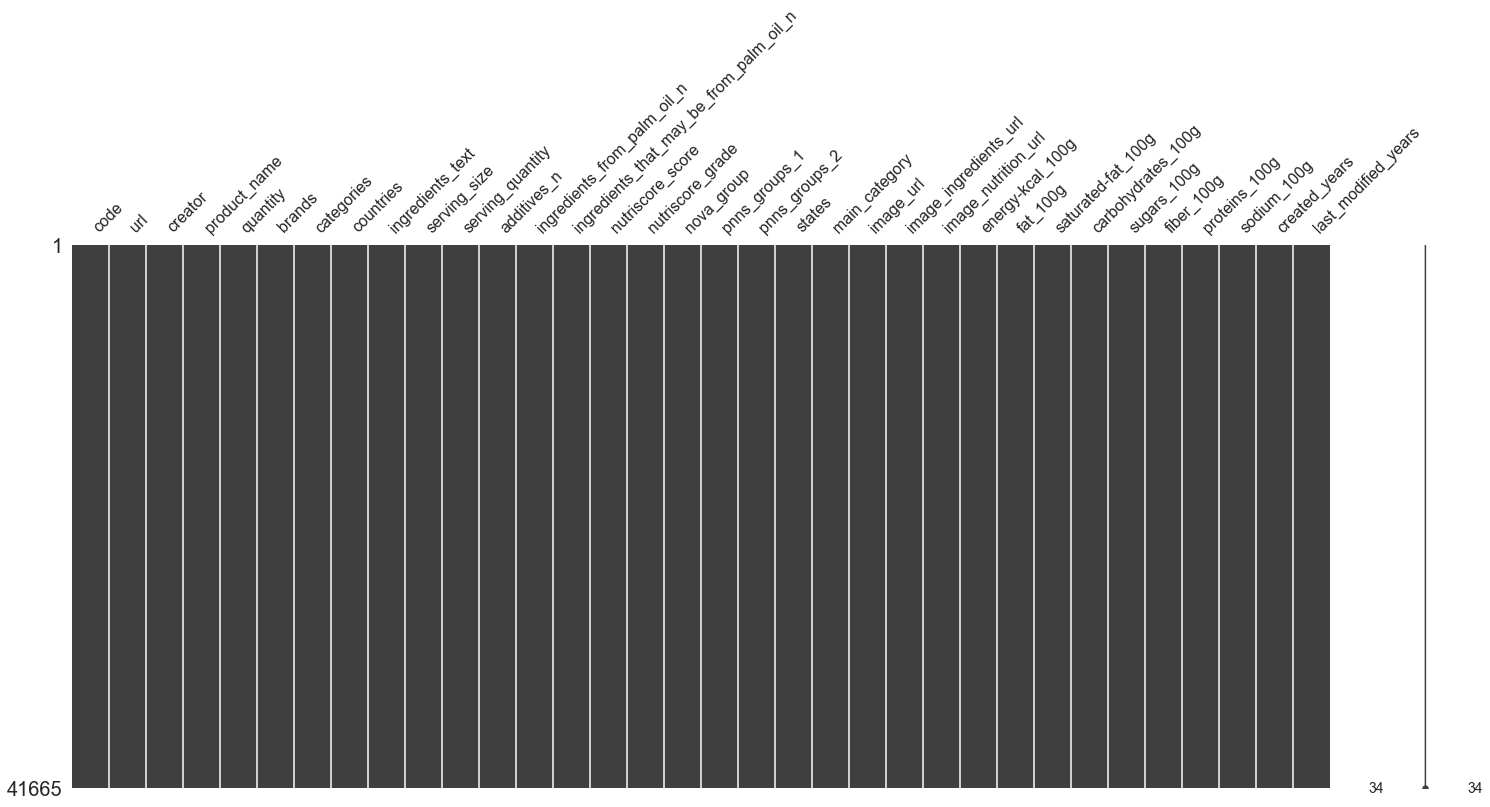

In [33]:
%matplotlib inline
msno.matrix(df_clean_no_na)

In [34]:
df_clean_no_na.describe()

,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,created_years,last_modified_years
count,41665.000000,41665.000000,41665.000000,41665.000000,41665.000000,41665.000000,41665.000000,41665.000000,41665.000000,41665.000000
mean,274.967729,12.226430,4.380602,32.454609,12.281594,3.097486,7.602350,0.364395,2016.995584,2020.385431
std,183.736680,14.868797,6.788625,26.841888,16.160243,4.338690,7.440349,1.381735,2.158141,0.899647
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2012.000000,2013.000000
25%,103.000000,1.600000,0.300000,7.600000,1.500000,0.500000,2.700000,0.036300,2015.000000,2020.000000
50%,265.000000,6.600000,1.700000,24.300000,4.500000,2.000000,6.200000,0.210526,2017.000000,2021.000000
75%,420.000000,19.000000,5.600000,58.000000,18.000000,4.000000,10.000000,0.440000,2019.000000,2021.000000
max,900.000000,100.000000,100.000000,100.000000,100.000000,100.000000,93.000000,93.500000,2021.000000,2021.000000


In [35]:
df_clean_no_na.shape

(41665, 34)

In [36]:
df_clean_no_na.to_csv("datasets/openfoodfacts_clean.csv", index=False)

On remarque que ce nettoyage produit un jeu de données plus restreint. On peut le sauvegarder pour l'utiliser par la suite. Cependant, le choix de travailler sur un jeu de données où les valeurs manquantes sont remplacées par une autre valeur semble plus judicieux. 

### B) Remplacement des valeurs manquantes par la moyenne

Tout d'abord, on crée une copie de notre dataset. Ensuite, on décide d'enlever toutes les lignes où le nom du produit ne figure pas. Après cette suppression, on choisit d'imputer les valeurs manquantes en utilisant la médiane en fonction de la variable pnns_groups_2. La médiane permet de ne pas prendre en compte les valeurs extrêmes qui pourraient être présentes dans le jeu de données. La variable pnns_groups_2 est celle où il y a le moins de valeurs manquantes ce qui signifie qu'il y aura plus d'imputation qu'avec une variable ayant plus de donneés manquantes.

In [37]:
# On crée une copie

df_clean_median = df.copy()
df_clean_median.dropna(subset=['product_name'], inplace=True) 

In [39]:
# Cette imputation est réaliser uniquement pour les valeurs numériques

for cols in df_clean_median.columns:
    if df_clean_median[cols].dtypes == "float64":
        df_clean_median[cols].fillna(df_clean_median.groupby('pnns_groups_2')[cols].transform('median'), inplace=True)

- Traitement des chaînes de caractères

Ce dataset sera celui utilisé dans la suite de notre analyse. Des traitements supplémentaires ont été réalisés suite à des aller-retours entre l'exploration et le nettoyage. Tout d'abord, on remplace les valeurs manquantes des catégories par une valeur *unknown* au lieu de laisser un NaN. Concernant les pays, on remplace les pays manquants par la valeur *other*. Ces modifications empêcheront le retrait de la ligne lors de l'utilisation de la fonction dropna. 

In [40]:
df_clean_median["countries"].fillna("other", inplace=True)

In [41]:
df_clean_median["categories"].fillna("unknown", inplace=True)

Les différents allers-retours entre analyse et exploration ont permis de relever des erreurs dûs à l'entrée des noms de manière manuelle. On va donc rendre certaines écritures plus homogènes pour éviter qu'un même produit ne soit considéré comme plusieurs produits. Cette logique a été appliquer aux pays en y appliquant un dictionnaire contenant les traductions des noms de pays. 

In [42]:
product = {
    "escalope de poulet" : "Escalopes de poulet",
    "aiguilette de poulet" : "Aiguilettes de poulet",
    "blanc de poulet" : "Blancs de poulet",
    "filet de poulet" : "Filets de poulet",
    "escalope de dinde" : "Escalopes de dinde",
    "aiguilette de dinde" : "Aiguilettes de dinde",
    "blanc de dinde" : "Blancs de dinde",
    "aiguilette de canard" : "Aiguilettes de canard",
    "Ice Cream" : "Ice Cream",
    "Crème glacée" : "Ice Cream",
    "yogurt" : "Yaourt",
    "Filetes de pollo empanado" : "Filets de poulet panés",
    "Cacao en polvo" : "Cacao",
    }

In [43]:
# Modification des chaînes de caractères en lien avec les noms de produits

for key, value in product.items():
    df_clean_median["product_name"].loc[df_clean_median["product_name"].str.contains(key, case=False, regex=False)] = value

In [44]:
countries_translate ={
    "France" : "France",
    "Francia" : "France",
    "Frankreich" : "France",
    "fr" : "France",
    "Germany" : "Allemagne",
    "Deutschland" : "Allemagne",
    "de" : "Allemagne",
    "España" : "Espagne",
    "Spain" : "Espagne",
    "en:es" : "Espagne",
    "United States" : "Etats-Unis",
    "USA" : "Etats-Unis",
    "Us" : "Etats-Unis",
    "United Kingdom" : "Royaume-Uni",
    "united-kingdom" : "Royaume_Uni",
    "England" : "Angleterre",
    "Scotland" : "Ecosse",
    "Ireland" : "Irlande",
    "Wales" : "Pays de Galles",
    "Polska" : "Pologne",
    "México" : "Mexique",
    "mexico" : "Mexique",
    "Belgium" : "Belgique",
    "be" : "Belgique",
    "Netherlands" : "Pays-Bas",
    "Magyarország" : "Hongrie",
    "Hungary" : "Hongrie",
    "new caledonia" : "Nouvelle-Calédonie",
    "Switzerland" : "Suisse",
    "Sverige" : "Suède",
    "Sweden" : "Suède",
    "Norway" : "Norvège",
    "Norge" : "Norvège",
    "Suomi" : "Finlande",
    "Finland" : "Finlande",
    "Bulgaria" : "Bulgarie",
    "България" : "Bulgarie",
    "Bǎlgarija" : "Bulgarie",
    "Россия" : "Russie",
    "Russia" : "Russie",
    "Italy" : "Italie",
    "Italia" : "Italie",
    "Thailand" : "Thaïlande",
    "Canada" : "Canada",
    "Brazil" : "Brésil",
    "Réunion" : "France",
    "Républik kongo" : "République du Congo",
    "Republik kongo" : "République du Congo",
    "Congo" : "République du Congo",
    "Mo" : "Macao",
    "malaysia" : "Malaisie",
    "my" : "Malaisie",
    "singapore" : "Singapour",
    "Jemen" : "Yémen",
    "mali" : "Mali",
    "Burkina faso" : "Burkina Faso",
    "En:sr" : "Singapour",
    "En:ye" : "Yémen",
    "Nueva zelanda" : "Nouvelle-Zélande",
    "New Zealand" : "Nouvelle-Zélande",
    "Taiwan" : "Taiwan",
    "Sn" : "Sénégal",
    "Senegal" : "Sénégal",
    "Grecia" : "Grèce",
    "Ελλάδα " : "Grèce",
    "Nueva caledonia" : "Nouvelle Calédonie",
    "lu" : "Luxembourg",
    "united-states" : "Etats-Unis",
    "En:it" : "Italie",
    "En:ivory coast" : "Cote d'Ivoire",
    "Schweiz" : "Suisse",
    "Slovenia" : "Slovénie",
    "ફ્રાન્સ" : "France",
    "En:ae" : "Emirats arabes unis",
    "united arab emirates" : "Emirats arabes unis",
    "dominican republic" : "République dominicaine",
    "En:re" : "France",
    "En:gb" : "Royaume-Uni",
    "Great Britain" : "Royaume-Uni",
    "En:ch" : "Suisse",
    "En:ca" : "Canada",
    "saudi arabi" : "Arabie Saoudite",
    "Romania" : "Roumanie",
    "En:pl" : "Pologne",
    "Chile" : "Chili",
    "En:el salvador" : "Salvador",
    "En:luxembourg" : "Luxembourg",
    "luxemburg" : "Luxembourg",
    "Stati uniti d'america" : "Etats-Unis",
    "En:ie" : "Irlande",
    "En:ad" : "Andorre",
    "royaume-uni" : "Royaume-Uni",
    "sv" : "Salvador",
    "En:jersey" : "Jersey",
    "jersey" : "Jersey",
    "En:gi" : "Gibraltar",
    "República dominicana" : "République dominicaine",
    "En:hk" : "Hong Kong",
    "En:mu" : "Ile Maurice",
    "En:uk" : "Royaume-Uni",
    "En:cr" : "Costa Rica",
    "En:portugal" : "Portugal",
    "Vereinigte staaten von amerika" : "Etats-Unis",
    "En: kuweit" : "Koweit",
    "En:hn" : "Honduras",
    "En:au" : "Australie",
    "En:at" : "Autriche",
    "En:pr" : "Porto Rico",
    "En:mc" : "Macao",
    "Hrvatska" : "Croatie",
    "En:egypt" : "Egypte",
    "Égypte" : "Egypte",
    "En:mx" : "Mexique",
    "En:pakistan" : "Pakistan",
    "En:pm" : "France",
    "En:pa" : "Panama",
    "En:ma" : "Maroc",
    "澳大利亚" : "Australie",
    "En:do" : "République dominicaine",
    "Estados unidos" : "Etats-Unis",
    "السعودية" : "Arabie Saoudite",
    "Saudi-arabien" : "Arabie Saoudite",
    "العراق" : "Iraq",
    "En:sa" : "Arabie Saoudite",
    "En:om" : "Oman",
    "gp" : "France",
    "pf" : "France",
    "El-salvador" : "Salvador",
    "En:indonesia" : "Indonésie",
    "الكويت" : "Koweit",
    "colombia" : "Colombie",
    "Martinique" : "France",
    "Guadeloupe" : "France",
    "Guyane" : "France",
    "En:czechia" : "République Tchèque",
    "En:puerto rico" : "Puerto Rico",
    "美国" : "Etats-Unis",
    "En:sg" : "Singapour",
    "Reino unido" : "Royaume-Uni",
    "En:lb" : "Liban",
    "En:costa rica" : "Costa Rica",
    "En:tt" : "Trinité-Et-Tobago",
    "En:ve" : "Venuezela",
    "En:israel" : "Israël",
    "israel" : "Israel",
    "Saudi-arabia" : "Arabie Saoudite",
    "Panamá" : "Panama",
    "En:isle of man" : "Royaume-Uni",
    "En:nc" : "Nouvelle-Calédonie",
    "En:bs" : "Bahamas",
    "En:nl" : "Pays-Bas",
    "En:jm" : "Jamaïque",
    "Jamaique" : "Jamaïque",
    "Jamaica" : "Jamaïque",
    "ประเทศฝรั่งเศส" : "France",
    "En:iraq":"Iraq",
    "En:ke" : "Kenya",
    "Jordan" : "Jordanie",
    "Poland" : "Pologne",
    "En:honduras" : "Honduras",
    "لولايات المتحدة" : "Etats-Unis",
    "En:hong kong": "Hong Kong",
    "Prancūzija" : "France",
    "Vereinigtes königreich" : "Royaume-Uni",
    "En:guinea" : "Guinée",
    "En:algeria" : "Algérie",
    "法国" : "France",
    "香港" : "Hong Kong",
    "Hong kong" : "Hong Kong",
    "Costa-rica" : "Costa Rica",
    "En:nz" : "Nouvelle-Zélande",
    "En:ghana" : "Ghana",
    "En:yt" : "France",
    "Wielka brytania" : "Royaume-Uni",
    "Maurice" : "Ile Maurice",
    "En:sc" : "Seychelles",
    "En:ecuador" : "Equateur",
    "En:cl" : "Chili",
    "中华人民共和国" : "Chine",
    "ประเทศไทย" : "Thaïlande",
    "En:pt" : "Portugal",
    "En:vi" : "Etats-Unis",
    "En:cm" : "Cameroun",
    "En:mk" : "Macédoine",
    "En:qa": "Qatar",
    "En:qatar" : "Qatar",
    "En:venezuela" : "Venézuela",
    "China" : "Chine",
    "en:greece" : "Grèce",
    "en:th" : "Thaïlande",
    "en:vietnam" : "Vietnam",
    "Suisse" : "Suisse",
    "En:gt" : "Guatemala",
    "En:mq" : "France",
    "Serbia" : "Serbie",
    "En:jp" : "Japon",
    "En:in" : "Inde",
    "America" : "Etats-Unis",
    "En:niger" : "Niger",
    "Panama" : "Panama",
    "En:japan" : "Japon",
    "En:barbados" : "Barbades",
    "En:lybia" : "Lybie",
    "En:poland" : "Pologne",
    "En:je" : "Jersey",
    "En:co" : "Colombie",
    "Riunione" : "France",
    "Bahreïn" : "Bahreïn",
    "En:mm" : "Birmanie",
    "En:haiti" : "Haïti",
    "En:pk" : "Pakistan",
    "En:afghanistan" : "Afghanistan",
    "En:gh" : "Ghana",
    "En:suriname" : "Suriname",
    "Γαλλία" : "France",
    "Trinidad and Tobago" : "Trinité-Et-Tobago",
    "En:south korea" : "Corée du Sud",
    "En:jo" : "Jordanie",
    "En:hr" : "Croatie", 
    "En:sm" : "Saint-Marin",
    "San Marin" : "Saint-Marin",
    "الإمارات العربية المتحدة" : "Emirats arabes unis",
    "En:lybia" : "Lybie",
    "India" : "Inde",
    "En:guyana" : "Guyana",
    "En:antigua and barbuda" : "Antigua-et-Barbuda",
    "Espagne" : "Espagne",
    "En:py" : "Paraguay",
    "Bolivia" : "Bolivie",
    "En:tw" : "Taiwan",
    "En:kw" : "Koweit",
    "Mexique" : "Mexique",
    "Polen" : "Pologne",
    "Argentina":"Argentine",
    "The bahamas" : "Bahamas",
    "Perú" : "Pérou",
    "En:dz" : "Algérie",
    "Puerto Rico" : "Porto Rico",
    "En:ml" : "Mali",
    "Andorra" : "Andorre",
    "Suiza" : "Suisse",
    "Puerto-rico" : "Porto Rico",
    "En:gf" : "France",
    "En:bb" : "Barbade",
    "En:dj" : "Djibouti",
    "En:cw" : "Curaçao",
    "Danmark" : "Danemark",
    "En:ht" : "Haïti",
    "En:bm" : "Bermudes",
    "En:U.s." : "Etats-Unis",
    "En:U.s" : "Etats-Unis",
    "U.s." : "Etats-Unis",
    "U.s" : "Etats-Unis",
    "Mexico" : "Mexique",
    "En:iq" :"Iraq",
    "En:ai" : "Anguilla",
    "En:bq" : "Pays-Bas caribéens",
    "En:gd" : "Grenade",
    "Česko" : "République Tchèque",
    "Lebanon" : "Liban",
    "En:philippines" : "Philippines",
    "En:ro" : "Roumanie",
    "En:kazakhstan" : "Kazakhstan",
    "En:kaz" : "Kazakhstan",
    "En:kz" : "Kazakhstan",
    "En:ge" : "Géorgie",
    "Georgia" : "Géorgie",
    "Argentina" : "Argentine",
    "En:ar" : "Argentine",
    "En:bahrain" : "Bahreïn",
    "Japan" : "Japon",
    "En:aruba" : "Aruba",
    "Україна" : "Ukraine",
    "En:sx" : "Saint-Marin",
    "ประเทศสเปน" : "Espagne",
    "Франция" : "France",
    "En:tn" : "Tunisie",
    "Tunisia" : "Tunisie",
    "En:lc" : "Sainte-Lucie",
    "Saint-Pierre-et-Miquelon" : "France",
    "Saint Pierre et Miquelon" : "France",
    "Royaume_Uni" : "Royaume-Uni",
    "En:kuwait" : "Koweit",
    "Saint martin" : "Saint-Martin",
    "加拿大" : "Canada",
    "Kanada" : "Canada",
    "Österreich" : "Autriche",
    "En:cz" : "République Tchèque",
    "Saint Pierre and miquelon" : "France",
    "Meksico" : "Mexique",
    "كندا" : "Canada",
    "Canadá" : "Canada",
    "Канада" : "Canada",
    "En:gn" : "Guinée",
    "Sierra leone" : "Sierra Leone",
    "États-unis" : "Etats-Unis",
    "En:ua" : "Ukraine",
    "En:ci" : "Cote d'Ivoire",
    "En:la" : "Laos",
    "En:cd" : "République du Congo",
    "Ecuador" : "Equateur",
    "Mexiko" : "Mexique",
    "Espanya" : "Espagne",
    "România" : "Roumanie",
    "En:gg": "Guernesey",
    "En:bh": "Bahreïn",
    "En:is": "Islande",
    "フィンランド" : "Finlande",
    "Czech republic" : "République Tchèque",
    "Hungary" : "Hongrie",
    "En:peru" : "Pérou",
    "En:uruguay" : "Uruguay",
    "England" : "Royaume-Uni",
    "En:se" : "Suède",
    "En:ph" : "Philippines",
    "Turkey" : "Turquie",
    "En:il" : "Israël",
    "Ungaria" : "Hongrie",
    "En:iran" : "Iran",
    "En:northern mariana islands" : "Îles Mariannes du Nord",
    "En:guatemala" : "Guatemala",
    "En:pe" : "Pérou",
    "En:cg" : "République du Congo",
    "European Union" : "Union européenne",
    "Hongkong" : "Hong Kong",
    "الأردن" : "Jordanie",
    "Србија" : "Serbie",
    "En:eg" : "Egypte",
    "Egypt" : "Egypte",
    "Indonesia" : "Indonésie",
    "Cambodia" : "Cambodge",
    "En:brunei" : "Brunei",
    "En:ec" : "Equateur",
    "En:no" : "Norvège",
    "En:grenada" : "Grenade",
    "En:zm" : "Zambie",
    "Albania" : "Albanie",
    "Iceland" : "Islande",
    "En:kh" : "Cambodge",
    "Бельгія" : "Belgique",
    "Portugal" : "Portugal",
    "En:gr" : "Grèce",
    "Algeria" : "Algérie",
    "En:sudan" : "Soudan",
    "En:ss" : "Soudan du Sud",
    "En:bj" : "Bénin",
    "Dinamarca" : "Danemark",
    "En:mt" : "Malte",
    "En:br" : "Brésil",
    "En:md" : "",
    "Greece" : "Grèce",
    "En:azerbaijan" : "Azerbaidjan" ,
    "En:fi" : "Fidji",
    "En:vn" : "Vietnam",
    "Ελλάδα" : "Grèce",
    'Peru' : "Pérou",
    "Sri lanka" : "Sri Lanka",
    'En:kyrgyzstan' : "Kyrgyzstan",
    'En:rs' : "Sénégal",
    'Unión europea' : "Union Européenne",
    "ישראל" : "Gabon",
    "jp" : "Japon",
    "en:sa" : "Arabie Saoudite",
    "za" : "Afrique du Sud",
    "Bélgica" : "Belgique",
    "Fi" : "Finlande",
    'Cameroon' : "Cameroun",
    "Messico" : "Mexique",
    'En:nicaragua' : "Nicaragua",
    'En:kn' : "Saint-Kitts-et-Nevis",
    'En:id' : "Indonésie",
    'En:ne' : "Niger",
    'En:bg' : "Bulgarie",
    "تونس" : "Tunisie",
    "Kw" : "Koweit",
    "Sa" : "Arabie Saoudite",
    "En:mr" : "Mauritanie",
    "En:tr" : "Turquie",
    "Bb" : "Barbades",
    "Ue" : "Union Européenne",
    "En:rwanda" : "Rwanda",
    "En:np" : "Népal",
    "Fi" : "Finlande",
    "Ru" : "Russie",
    "الجزائر" : "Algérie",
    "Autriche" : "Autriche",
    "Hellas" : "Grèce",
    "en:km" : "Comores",
    "no" : "Norvège",
    "en:bd" : "Bangladesh",
    "Nepal" : "Népal",
    "لبنان" : "Liban",
    "Kowait" : "Koweit",
    "en:ethyopia" : "Ethiopie",
    "Coronaponpis" : "Espagne",
    "Angleterre" : "Royaume-Uni",
    "Italien" : "Italie",
    "Alemania" : "Allemagne",
    "En:gabon" : "Gabon",
    "البرتغال" : "Portugal",
    "Slovénie" : "Slovénie",
    "Hong-Kong" : "Hong Kong",
    "En:angola" : "Angola",
    "Lietuva" : "Lituanie",
    "En:guam" : "Guam",
    "En:tg" : "Togo"
}

In [45]:
# Modification des chaînes de caractères en lien avec les pays
# Ce choix a été fait car nous aurons besoin des noms de pays pour notre application
for key, value in countries_translate.items():
    df_clean_median["countries"].loc[df_clean_median["countries"].str.contains(key, case=False, regex=False)] = value

<AxesSubplot:>

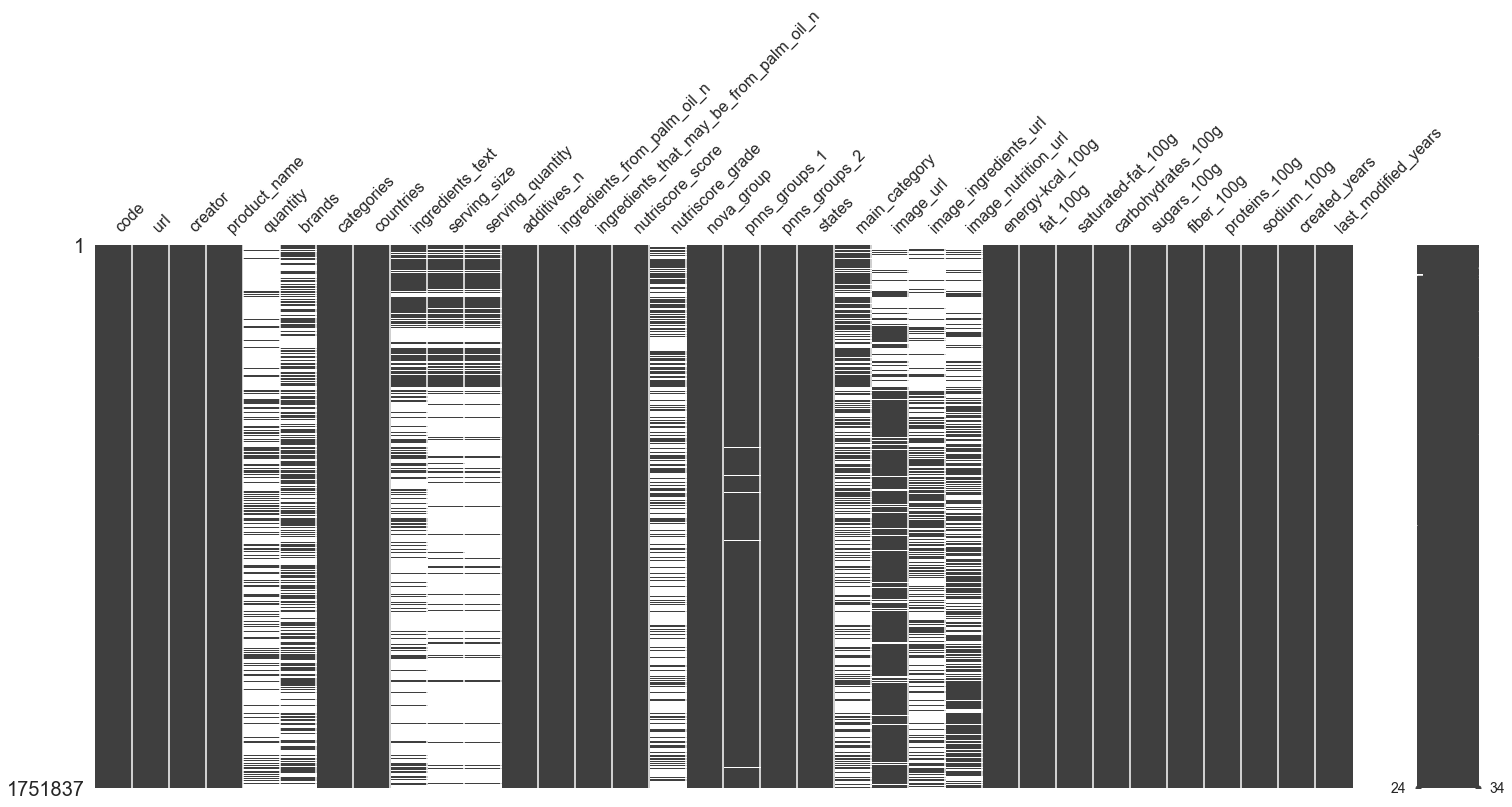

In [46]:
msno.matrix(df_clean_median)

In [47]:
df_clean_median.shape

(1751837, 34)

In [48]:
df_clean_median.to_csv("datasets/openfoodfacts_clean_median.csv", index=False)

Ce jeu de données contient plus de données et peu de données manquantes. On utilisera donc celui-ci pour la suite de notre analyse. 

### C) Fichier en l'état sans nettoyer enlever les valeurs manquantes

In [ ]:
df_clean = df.copy()

In [ ]:
msno.matrix(df_clean)

In [ ]:
df_clean.shape

In [ ]:
df_clean.to_csv("datasets/openfoodfacts_clean_data.csv", index=False)